# North Atlantic SST bias

In [60]:
import numpy as np
import xarray as xr
import cmocean
from dask.distributed import Client, LocalCluster, wait
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

In [61]:
plt.style.use('dark_background')

In [62]:
cluster = LocalCluster(n_workers=8, threads_per_worker=2, memory_limit='32GB',
                       silence_logs=50)
client = Client(address=cluster)
client

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35865 instead
  expected, actual


Client Scheduler: tcp://127.0.0.1:41939 Dashboard: http://127.0.0.1:35865/status,Cluster Workers: 8 Cores: 16 Memory: 238.42 GiB


## Mesh

In [63]:
ds_m = xr.open_dataset('/gxfs_work1/geomar/smomw352/mask_orca12.nc')
tmask = ds_m['tmask'][0,:,:,:]
ds_h = xr.open_dataset('/gxfs_work1/geomar/smomw352/mesh_hgr_orca12.nc')
ds_z = xr.open_dataset('/gxfs_work1/geomar/smomw352/mesh_zgr_orca12.nc')
e1t = ds_h['e1t'][0,:,:]
e2t = ds_h['e2t'][0,:,:]
areacello = e1t * e2t
dz_1d = ds_z['e3t_1d'][0,:].rename({'z':'deptht'})
dz_1d

<xarray.DataArray 'e3t_1d' (deptht: 75)>
array([  1.023461,   1.078726,   1.147423,   1.232879,   1.339123,   1.470915,
         1.633704,   1.833421,   2.076075,   2.367091,   2.710405,   3.107473,
         3.556467,   4.052057,   4.586102,   5.14928 ,   5.733272,   6.332855,
         6.947313,   7.580885,   8.242412,   8.944527,   9.702774,  10.534883,
        11.460308,  12.5     ,  13.676367,  15.013316,  16.536325,  18.272469,
        20.250356,  22.499913,  25.051989,  27.937733,  31.187703,  34.830693,
        38.892269,  43.393035,  48.346692,  53.758006,  59.620831,  65.916409,
        72.612175,  79.661292,  87.003129,  94.56478 , 102.263617, 110.01072 ,
       117.714916, 125.287027, 132.643934, 139.712047, 146.429921, 152.749833,
       158.638314, 164.075738, 169.055152, 173.580595, 177.665122, 181.328752,
       184.596508, 187.496638, 190.059109, 192.314376, 194.292431, 196.022102,
       197.53058 , 198.843117, 199.982871, 200.97086 , 201.825999, 202.565181,
       203.203408, 203.75393 , 204.228397])
Dimensions without coordinates: deptht

In [64]:
ds_m05 = xr.open_dataset('/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc')
tmask05 = ds_m05['tmask'][0,:,:,:]
e1t_05 = ds_m05['e1t'][0,:,:]
e2t_05 = ds_m05['e2t'][0,:,:]
areacello_05 = e1t_05 * e2t_05
dz_1d_05 = ds_m05['e3t_0'][0,:].rename({'z':'deptht'})

In [65]:
def vint(_data, _dz):
    _tdz = _dz.sum('z')
    _ddz = (_data * _dz).sum('z')
    return _ddz/_tdz

In [66]:
def sfcmean(data, xmin, xmax, ymin, ymax):
    
    weights = (areacello * tmask[0,:,:]).fillna(0).sel(x=slice(xmin,xmax), y=slice(ymin,ymax))
    weights.name = "weights"
    data_weighted = data.weighted(weights)
    weighted_mean = data_weighted.mean(("x", "y"))
    
    return weighted_mean

def sfcmean05(data, xmin, xmax, ymin, ymax):
    
    weights = (areacello_05 * tmask05[0,:,:]).fillna(0).sel(x=slice(xmin,xmax), y=slice(ymin,ymax))
    weights.name = "weights"
    data_weighted = data.weighted(weights)
    weighted_mean = data_weighted.mean(("x", "y"))
    
    return weighted_mean

In [67]:
expnames = ['FOCI_GJK012','FOCI_BJK017','FOCI_BJK019']
times = [slice('1950-02-01','1959-12-31'),slice('1950-02-01','1952-12-31'),slice('1953-01-01','1959-12-31')]

In [68]:
t_1m_all = []

for i, (exp,time) in enumerate( zip(expnames, times) ):
    
    # some files from 1959 are dead links, 
    # check gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/nemo/
    time_str = '195[0-9]????_*' 
    chunks = {'x':None, 'y':None, 'deptht': 1, 'depthu':1, 'depthv':1, 'time_counter': 1} 
    #chunks = {'x':500, 'y':500, 'deptht': 1, 'depthu':1, 'depthv':1, 'time_counter': None}
    
    ddir = '/gxfs_work1/geomar/smomw352/esm-experiments/%s/outdata/nemo/' % (exp,)
    if exp == 'FOCI_BJK017':
        tfiles = '%s/%s_1m3_%s_grid_T.nc' % (ddir,exp,time_str)
    else:
        tfiles = '%s/%s_1m_%s_grid_T.nc' % (ddir,exp,time_str)
    print(tfiles)
    t_1m = xr.open_mfdataset(tfiles,combine='nested', 
                             concat_dim="time_counter", chunks=chunks,
                             data_vars='minimal', coords='minimal', compat='override',
                             parallel=True).rename({'time_counter':'time', 'nav_lat':'lat', 'nav_lon':'lon'}).sel(time=time)
    if exp == 'FOCI_BJK019': 
        t_1m_all.append(t_1m.drop('time_centered'))
    else:
        t_1m_all.append(t_1m)
    

/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK012/outdata/nemo//FOCI_GJK012_1m_195[0-9]????_*_grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK017/outdata/nemo//FOCI_BJK017_1m3_195[0-9]????_*_grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/nemo//FOCI_BJK019_1m_195[0-9]????_*_grid_T.nc


In [69]:
# Merge BJK017 and BJK019 to one
_ll = [t_1m_all[1].drop(['time_counter_bnds', 'deptht_bnds']), t_1m_all[2].drop('deptht_bounds')]
_ds = xr.concat( _ll, dim='time' )

In [70]:
t_1m_all = [t_1m_all[0], _ds]

In [71]:
def to_orca12(x_orca05, y_orca05):
    x_orca12 = x_orca05 * 6
    y_orca12 = y_orca05 * 6
    return x_orca12, y_orca12

## Plot North Atlantic

In [13]:
sst = t_1m_all[0]['toce'][-1,:,:,:].sel(deptht=0,method='nearest')

In [14]:
sst12 = t_1m_all[1]['toce'][-1,:,:,:].sel(deptht=0,method='nearest')

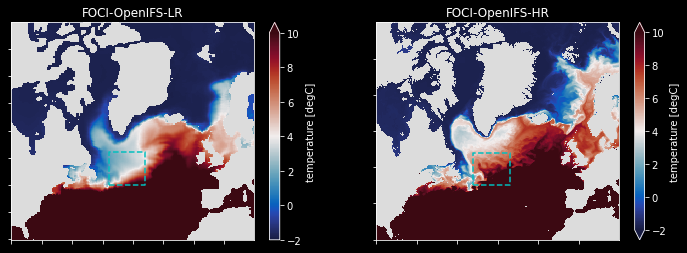

In [15]:
xmin, xmax = 400, 600
ymin, ymax = 300, 500

xbox1, xbox2 = 480, 510
ybox1, ybox2 = 350, 380

fig1, ax1 = plt.subplots(1,2,figsize=(12,4))
z1 = sst[ymin:ymax, xmin:xmax]
z1.where(z1 != 0).plot(ax=ax1[0], vmin=-2, vmax=10, cmap=cmocean.cm.balance, rasterized=True)
ax1[0].plot([xbox1-xmin, xbox2-xmin, xbox2-xmin, xbox1-xmin, xbox1-xmin], 
            [ybox1-ymin, ybox1-ymin, ybox2-ymin, ybox2-ymin, ybox1-ymin], '--c')

xmin12, ymin12 = to_orca12(xmin, ymin)
xmax12, ymax12 = to_orca12(xmax, ymax)
xbox121, ybox121 = to_orca12(xbox1, ybox1)
xbox122, ybox122 = to_orca12(xbox2, ybox2)

z2 = sst12[ymin12:ymax12, xmin12:xmax12]
z2.where(z2 != 0).plot(ax=ax1[1], vmin=-2, vmax=10, cmap=cmocean.cm.balance, rasterized=True)
ax1[1].plot([xbox121-xmin12, xbox122-xmin12, xbox122-xmin12, xbox121-xmin12, xbox121-xmin12], 
            [ybox121-ymin12, ybox121-ymin12, ybox122-ymin12, ybox122-ymin12, ybox121-ymin12], '--c')

for ax in ax1:
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.set_ylabel('')
    ax.set_yticklabels([])
    ax.set_facecolor('Gainsboro')

ax1[0].set_title('FOCI-OpenIFS-LR')
ax1[1].set_title('FOCI-OpenIFS-HR')
fig1.savefig('figures/sst_with_box.pdf',format='pdf',dpi=150)

In [16]:
sst1 = (t_1m_all[0]['toce']).sel(deptht=0,method='nearest').sel(x=slice(xbox1, xbox2), y=slice(ybox1, ybox2))
sst1_mean = sst1.mean(('x','y')) #sfcmean(sst1, xbox1, xbox2, ybox1, ybox2).compute()

In [17]:
sst2 = (t_1m_all[1]['toce']).sel(deptht=0,method='nearest').sel(x=slice(xbox121, xbox122), y=slice(ybox121, ybox122))
sst2_mean = sst2.mean(('x','y')) #sfcmean(sst2, xbox121, xbox122, ybox121, ybox122)

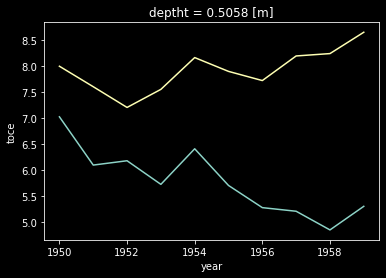

In [18]:
fig1, ax1 = plt.subplots(1,1) 
sst1_mean.groupby('time.year').mean('time').plot(ax=ax1, label='LR')
sst2_mean.groupby('time.year').mean('time').plot(ax=ax1, label='HR')

In [23]:
t1 = (t_1m_all[0]['toce'] * dz_1d_05).sel(deptht=slice(0,10)).mean('deptht').sel(x=slice(xbox1, xbox2), y=slice(ybox1, ybox2))
#t1 = (t_1m_all[0]['toce']).sel(deptht=0,method='nearest').sel(x=slice(xbox1, xbox2), y=slice(ybox1, ybox2))
t1_mean = t1.mean(('x','y')) 

In [24]:
t2 = (t_1m_all[1]['toce'] * dz_1d).sel(deptht=slice(0,10)).mean('deptht').sel(x=slice(xbox121, xbox122), y=slice(ybox121, ybox122))
#t2 = (t_1m_all[1]['toce']).sel(deptht=0,method='nearest').sel(x=slice(xbox121, xbox122), y=slice(ybox121, ybox122))
t2_mean = t2.mean(('x','y')) 

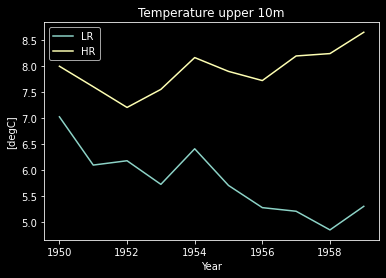

In [28]:
fig1, ax1 = plt.subplots(1,1) 
sst1_mean.groupby('time.year').mean('time').plot(ax=ax1, label='LR')
sst2_mean.groupby('time.year').mean('time').plot(ax=ax1, label='HR')
ax1.set_title('Temperature upper 10m')
#ax1.set_title('SST')
ax1.set_xlabel('Year')
ax1.set_ylabel('[degC]')
ax1.legend()
fig1.savefig('figures/sst_natl.pdf',format='pdf')

## Temperature tendencies

$$
T_t = T_\mathrm{adv} + T_\mathrm{ldf} + T_\mathrm{zdfp} + T_\mathrm{qsr} + T_\mathrm{qns} + T_\mathrm{af} 
$$

Note: If lateral diffusion is purely lateral, then "ldf" is lateral and "zdf" is vertical. 
If lateral diffusion is iso-neutral, then zdfp is "pure" vertical diffusion, i.e. diffusion by vertical diffusivity, 
$$
T_\mathrm{zdfp} = A_\mathrm{v,t} \frac{\partial T}{\partial z} 
$$
When using iso-neutral diffusion, there may be a vertical component in the "lateral" diffusion. 
"ldf" is diffusion by the "ldf" routine, which is iso-neutral in most cases. 

Also note: Eddy-induced trends (eiv) are included in "adv", not "ldf". 

In [30]:
tend_list = ['had','zad','ldf','zdf','zdfp','qsr','qns']

xbox1, xbox2 = 480, 510
ybox1, ybox2 = 350, 380

ds_trd = []
for i,t_1m in enumerate(t_1m_all):
    
    if i == 0:
        x1,x2,y1,y2 = xbox1, xbox2, ybox1, ybox2
        _dz = dz_1d_05
    elif i == 1:
        x1,y1 = to_orca12(xbox1, ybox1)
        x2,y2 = to_orca12(xbox2, ybox2) 
        _dz = dz_1d
    
    _res = []
    for t in tend_list:
        
        if t == 'had':
            #_trd = ((t_1m['ttrd_xad'] + t_1m['ttrd_yad']) * _dz).sel(deptht=0,method='nearest').sel(x=slice(x1, x2), y=slice(y1, y2))
            _trd = ((t_1m['ttrd_xad'] + t_1m['ttrd_yad']) * _dz).sel(deptht=slice(0,10)).sum('deptht').sel(x=slice(x1, x2), y=slice(y1, y2))
        else:
            #_trd = (t_1m['ttrd_%s' % (t,)] * _dz).sel(deptht=0,method='nearest').sel(x=slice(x1, x2), y=slice(y1, y2))
            _trd = (t_1m['ttrd_%s' % (t,)] * _dz).sel(deptht=slice(0,10)).sum('deptht').sel(x=slice(x1, x2), y=slice(y1, y2))
        
        if i == 0:
            _trds = sfcmean05(_trd, x1, x2, y1, y2)
        elif i == 1:
            _trds = sfcmean(_trd, x1, x2, y1, y2)
            
        _trdm = _trds.groupby('time.year').mean('time').compute()
        #_trdm = _trd.mean(('x','y')).groupby('time.year').mean('time').compute()
        
        _trdm.name = 'ttrd_%s' % (t,)
        _res.append(_trdm.to_dataset())
        
    _ds = xr.merge(_res)
    ds_trd.append(_ds)

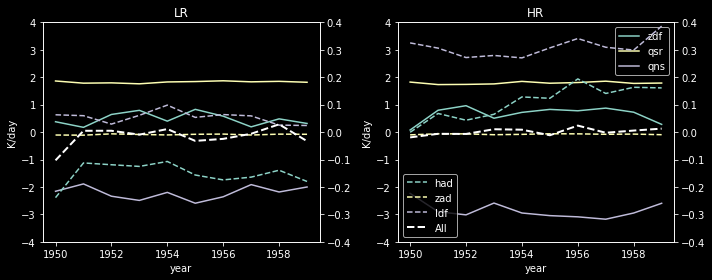

In [35]:
y1, y2 = 1952, 1959

# scale to per year
scale = 86400

fig1, ax1 = plt.subplots(1,2,figsize=(10,4))

#tend_list = ['had','zad','ldf','zdfp','qsr','qns']
tend_list = ['had','zad','ldf','zdf','qsr','qns']

for i in range(0,2):
    
    ax2 = ax1[i].twinx()
    
    for j, t in enumerate(tend_list):
        tt = 'ttrd_%s' % (t,)
        
        if t == 'zdf' or t == 'qsr' or t == 'qns':
            (ds_trd[i][tt] * scale).plot(ax=ax1[i], label=t)
        else:
            (ds_trd[i][tt] * scale).plot(ax=ax2, label=t, linestyle='--')
        
        if j == 0:
            _sum = ds_trd[i][tt] * scale
        else:
            _sum = _sum + ds_trd[i][tt] * scale
            
    _sum.plot(ax=ax2, label='All', linestyle='--', color='w', lw=2)
    
    vmax = 0.4
    ax2.set_ylim([-vmax,vmax])
    ax2.set_ylim([-vmax,vmax])
    if i == 1:
        ax2.legend()
        
for ax in ax1[1:]:
    ax.legend()
    
for ax in ax1:
    ax.set_ylabel('K/day')

vmax = 4
ax1[0].set_ylim([-vmax,vmax])
ax1[1].set_ylim([-vmax,vmax])
    
ax1[0].set_title('LR')
ax1[1].set_title('HR')

fig1.tight_layout()
fig1.savefig('figures/NAtl_sst_bias_tendencies.pdf',format='pdf')

## Plot difference in profiles

In [26]:
t_1m

<xarray.Dataset>
Dimensions:               (y: 3059, x: 4322, deptht: 75, axis_nbounds: 2, time: 84)
Coordinates:
    lat                   (y, x) float32 dask.array<chunksize=(3059, 4322), meta=np.ndarray>
    lon                   (y, x) float32 dask.array<chunksize=(3059, 4322), meta=np.ndarray>
  * deptht                (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
  * time                  (time) datetime64[ns] 1953-01-16T12:00:00 ... 1959-...
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/50)
    deptht_bounds         (deptht, axis_nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    toce                  (time, deptht, y, x) float32 dask.array<chunksize=(1, 1, 3059, 4322), meta=np.ndarray>
    soce                  (time, deptht, y, x) float32 dask.array<chunksize=(1, 1, 3059, 4322), meta=np.ndarray>
    mldr10_1              (time, y, x) float32 dask.array<chunksize=(1, 3059, 4322), meta=np.ndarray>
    ...                    ...
    ttrd_qns              (time, deptht, y, x) float32 dask.array<chunksize=(1, 1, 3059, 4322), meta=np.ndarray>
    strd_cdt              (time, deptht, y, x) float32 dask.array<chunksize=(1, 1, 3059, 4322), meta=np.ndarray>
    ttrd_qsr              (time, deptht, y, x) float32 dask.array<chunksize=(1, 1, 3059, 4322), meta=np.ndarray>
    ttrd_bbc              (time, deptht, y, x) float32 dask.array<chunksize=(1, 1, 3059, 4322), meta=np.ndarray>
    ttrd_atf              (time, deptht, y, x) float32 dask.array<chunksize=(1, 1, 3059, 4322), meta=np.ndarray>
    strd_atf              (time, deptht, y, x) float32 dask.array<chunksize=(1, 1, 3059, 4322), meta=np.ndarray>
Attributes:
    name:         FOCI_BJK019_1m_19530101_19530131_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2022-Aug-24 02:53:47 GMT
    uuid:         f26ac28d-d7a0-43dc-96a7-25d1dab974b3
    history:      Thu Sep  1 12:29:07 2022: ncks -O -7 --no-alphabetize -L 1 ...
    NCO:          netCDF Operators version 4.9.1 (Homepage = http://nco.sf.ne...

In [75]:
tend_list = ['had','zad','ldf','zdfp','qsr','qns']

ds_trd_p = []
for i,t_1m in enumerate(t_1m_all):
    
    if i == 0:
        x1,x2,y1,y2 = xbox1, xbox2, ybox1, ybox2
        _dz = dz_1d_05
    elif i == 1:
        x1,y1 = to_orca12(xbox1, ybox1)
        x2,y2 = to_orca12(xbox2, ybox2) 
        _dz = dz_1d
    
    _res = []
    for t in tend_list:
        
        if t == 'had':
            _trd = ((t_1m['ttrd_xad']+t_1m['ttrd_yad']) * _dz).sel(x=slice(x1, x2), y=slice(y1, y2))
        else:
            _trd = (t_1m['ttrd_%s' % (t,)] * _dz).sel(x=slice(x1, x2), y=slice(y1, y2))
        _trdm = _trd.mean(('x','y')).groupby('time.year').mean('time').compute()
        
        _trdm.name = 'ttrd_%s' % (t,)
        _res.append(_trdm.to_dataset())
        
    _ds = xr.merge(_res)
    
    ds_trd_p.append(_ds)
    

<xarray.DataArray 'ttrd_had' (deptht: 46)>
array([-9.36985610e-07, -1.03396829e-06, -1.06890943e-06, -1.08121569e-06,
       -1.08666119e-06, -1.11407106e-06, -1.14350281e-06, -1.16840182e-06,
       -1.03467513e-06, -7.09918558e-07, -4.31588761e-07, -3.73966749e-07,
       -2.26689602e-07, -1.77959066e-07, -1.62064383e-07, -1.60792862e-07,
       -1.52241249e-07, -1.14083662e-07, -5.28214786e-08, -3.30003170e-08,
       -6.57514899e-08, -8.09053116e-08, -1.16838282e-07, -1.28244843e-07,
       -1.50989325e-07, -1.69666579e-07, -2.26463897e-07, -2.61305422e-07,
       -2.77664955e-07, -2.36746992e-07, -1.17626399e-07, -2.81365703e-08,
        4.87571178e-08,  5.18107524e-08,  4.28326066e-08,  2.82259403e-08,
        5.93186647e-09,  2.42885599e-09, -3.36002265e-10, -3.56723070e-09,
       -2.66295069e-09,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])
Coordinates:
  * deptht   (deptht) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
<xarr

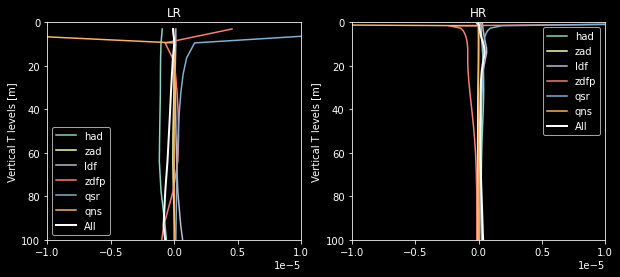

In [95]:
fig1, ax1 = plt.subplots(1,2,figsize=(10,4))
    
for i in range(0,2):
    if i == 0:
        y1, y2 = 1950, 1959
    elif i == 1:
        y1, y2 = 1953, 1958
        
    for j, t in enumerate(tend_list):
        tt = 'ttrd_%s' % (t,)
        d1 = ds_trd_p[i][tt].sel(year=y1)
        d2 = ds_trd_p[i][tt].sel(year=y2)
        #_z = (d2-d1) #.cumsum('deptht')
        _z = ds_trd_p[i][tt].sel(year=slice(y2,y2)).mean('year')
        print(_z)
        _z.plot(y='deptht',ax=ax1[i], label=t)
        
        if j == 0:
            _sum = _z
        else:
            _sum = _sum +_z
    
    _sum.plot(y='deptht',ax=ax1[i], label='All', lw=2, color='w')

for ax in ax1:
    ax.legend()
    ax.invert_yaxis()
    ax.set_ylim([100,0])

ax1[0].set_xlim([-1e-5,1e-5])
ax1[1].set_xlim([-1e-5,1e-5])
    
ax1[0].set_title('LR')
ax1[1].set_title('HR')

fig1.savefig('figures/NAtl_sst_bias_tendencies_profiles_2.pdf',format='pdf')

## Southern Ocean

Text(0.5, 1.0, 'FOCI-OpenIFS-HR')

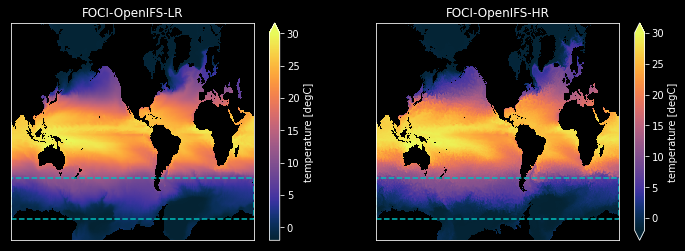

In [72]:
xmin, xmax = 1, 720
ymin, ymax = 1, 510

xbox1, xbox2 = 1, 720
ybox1, ybox2 = 50, 147

fig1, ax1 = plt.subplots(1,2,figsize=(12,4))
z1 = sst[ymin:ymax, xmin:xmax]
z1.where(z1!=0).plot(ax=ax1[0], vmin=-2, vmax=30, cmap=cmocean.cm.thermal)
ax1[0].plot([xbox1-xmin, xbox2-xmin, xbox2-xmin, xbox1-xmin, xbox1-xmin], 
            [ybox1-ymin, ybox1-ymin, ybox2-ymin, ybox2-ymin, ybox1-ymin], '--c')

xmin12, ymin12 = to_orca12(xmin, ymin)
xmax12, ymax12 = to_orca12(xmax, ymax)
xbox121, ybox121 = to_orca12(xbox1, ybox1)
xbox122, ybox122 = to_orca12(xbox2, ybox2)

z2 = sst12[ymin12:ymax12, xmin12:xmax12]
z2.where(z2!=0).plot(ax=ax1[1], vmin=-2, vmax=30, cmap=cmocean.cm.thermal)
ax1[1].plot([xbox121-xmin12, xbox122-xmin12, xbox122-xmin12, xbox121-xmin12, xbox121-xmin12], 
            [ybox121-ymin12, ybox121-ymin12, ybox122-ymin12, ybox122-ymin12, ybox121-ymin12], '--c')


for ax in ax1:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
ax1[0].set_title('FOCI-OpenIFS-LR')
ax1[1].set_title('FOCI-OpenIFS-HR')

In [73]:
sst1 = (t_1m_all[0]['toce'] * dz_1d_05).sel(deptht=slice(0,10)).sum('deptht').sel(x=slice(xbox1, xbox2), y=slice(ybox1, ybox2))
#sst1_mean = sst1.mean(('x','y')) #sfcmean(sst1, xbox1, xbox2, ybox1, ybox2).compute()
sst1_mean = sfcmean05(sst1, xbox1, xbox2, ybox1, ybox2).compute()

In [74]:
sst2 = (t_1m_all[1]['toce'] * dz_1d).sel(deptht=slice(0,10)).sum('deptht').sel(x=slice(xbox121, xbox122), y=slice(ybox121, ybox122))
#sst2_mean = sst2.mean(('x','y')) #sfcmean(sst2, xbox121, xbox122, ybox121, ybox122)
sst2_mean = sfcmean(sst2, xbox121, xbox122, ybox121, ybox122).compute()

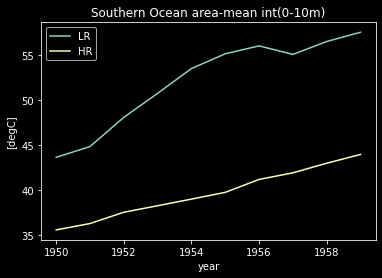

In [75]:
fig1, ax1 = plt.subplots(1,1) 
sst1_mean.groupby('time.year').mean('time').plot(ax=ax1, label='LR')
sst2_mean.groupby('time.year').mean('time').plot(ax=ax1, label='HR')
ax1.legend()
ax1.set_title('Southern Ocean area-mean int(0-10m)')
ax1.set_ylabel('[degC]')
fig1.savefig('figures/southern_ocean_sst.pdf',format='pdf')

In [76]:
tend_list = ['had','zad','ldf','zdf','zdfp','qsr','qns','npc','atf']
#tend_list = ['qns']

ds_trd = []
ds_trd_3d = []

for i,t_1m in enumerate(t_1m_all):
    
    if i == 0:
        x1,x2,y1,y2 = xbox1, xbox2, ybox1, ybox2
        _dz = dz_1d_05
    elif i == 1:
        x1,y1 = to_orca12(xbox1, ybox1)
        x2,y2 = to_orca12(xbox2, ybox2) 
        _dz = dz_1d
    
    print(x1,x2, y1, y2)
    
    _res = []
    for t in tend_list:
        
        if t == 'had':
            #_trd = (t_1m['ttrd_xad']+t_1m['ttrd_yad'] * _dz).sel(deptht=0,method='nearest').sel(x=slice(x1, x2), y=slice(y1, y2))
            _trd = (t_1m['ttrd_xad']+t_1m['ttrd_yad'] * _dz).sel(deptht=slice(0,10)).sum('deptht').sel(x=slice(x1, x2), y=slice(y1, y2))
            ds_trd_3d.append(_trd)
        else:
            #_trd = (t_1m['ttrd_%s' % (t,)] * _dz).sel(deptht=0,method='nearest').sel(x=slice(x1, x2), y=slice(y1, y2))
            _trd = (t_1m['ttrd_%s' % (t,)] * _dz).sel(deptht=slice(0,10)).sum('deptht').sel(x=slice(x1, x2), y=slice(y1, y2))
            ds_trd_3d.append(_trd)
        
        if i == 0:
            _trds = sfcmean05(_trd, x1, x2, y1, y2)
        elif i == 1:
            _trds = sfcmean(_trd, x1, x2, y1, y2)
        
        _trdm = _trds.groupby('time.year').mean('time').compute()
        
        _trdm.name = 'ttrd_%s' % (t,)
        _res.append(_trdm.to_dataset())
        
    _ds = xr.merge(_res)
    ds_trd.append(_ds)

1 720 50 147
6 4320 300 882


In [129]:
z1 = ds_trd_3d[0].groupby('time.month').mean('time').mean('month').compute()
z2 = ds_trd_3d[1].groupby('time.month').mean('time').mean('month').compute()

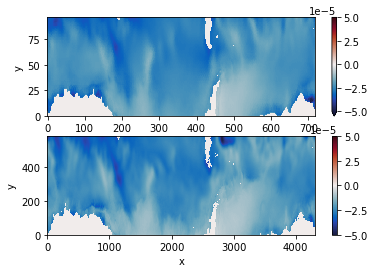

In [133]:
vmax = 5e-5
fig1, ax1= plt.subplots(2,1)
z1.plot(ax=ax1[0],vmin=-vmax,vmax=vmax,cmap=cmocean.cm.balance)
z2.plot(ax=ax1[1],vmin=-vmax,vmax=vmax,cmap=cmocean.cm.balance)

qsr-qns-zdf
qsr-qns-zdf


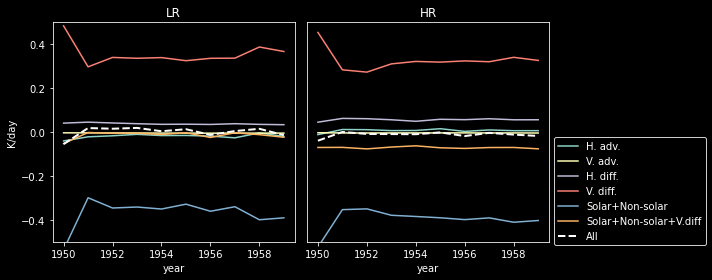

In [79]:
y1, y2 = 1952, 1959

# scale to per year
scale = 86400

fig1, ax1 = plt.subplots(1,2,figsize=(10,4))

tend_list = ['had','zad','ldf','zdf','qsr-qns','qsr-qns-zdf']
lab_list = ['H. adv.','V. adv.','H. diff.','V. diff.','Solar+Non-solar','Solar+Non-solar+V.diff']
#tend_list = ['had','zad','ldf','zdf','qsr','qns','atf']
#lab_list = ['H. adv.','V. adv.','H. diff.','V. diff.','Solar','Non-solar','Robert']

for i in range(0,2):
    
    #ax2 = ax1[i].twinx()
    
    _sum = 0
    for j, t in enumerate(tend_list):
        tt = 'ttrd_%s' % (t,)
        
        #if t == 'zdfp' or t == 'qsr' or t == 'qns':
        if t == 'qsr-qns':
            z = (ds_trd[i]['ttrd_qsr'] + ds_trd[i]['ttrd_qns']) * scale
        elif t == 'qsr-qns-zdf':
            z = (ds_trd[i]['ttrd_qsr'] + ds_trd[i]['ttrd_qns'] + ds_trd[i]['ttrd_zdf']) * scale
        else:
            z = ds_trd[i][tt] * scale
        
        z.plot(ax=ax1[i], label=lab_list[j])
        
        if j == 0:
            _sum = z
        elif t != 'qsr-qns-zdf':
            _sum = _sum + z
        else:
            print(t)
            
    #_sum.plot(ax=ax2, label='All', color='k', lw=2)
    _sum.plot(ax=ax1[i], label='All', color='w', linestyle='--',lw=2)
    
    #vmax = 0.1
    #ax2.set_ylim([-vmax,vmax])
    #ax2.set_ylim([-vmax,vmax])
    #if i == 1:
    #    ax2.legend()
        
for ax in ax1[1:]:
    ax.legend(bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True, shadow=True)
    
ax1[0].set_ylabel('K/day')

vmax = 0.5
ax1[0].set_ylim([-vmax,vmax])
ax1[1].set_ylim([-vmax,vmax])
    
ax1[0].set_title('LR')
ax1[1].set_title('HR')

ax1[1].tick_params(axis='y', which='both', left=False, labelleft=False)

fig1.tight_layout()
fig1.savefig('figures/SOce_sst_bias_tendencies.pdf',format='pdf')

## Plot cross section

In [48]:
tend_list = ['had','zad','ldf','zdfp','qsr','qns','npc']

ds_trd_zm = []
for i,t_1m in enumerate(t_1m_all):
    
    if i == 0:
        x1,x2,y1,y2 = xbox1, xbox2, ybox1, ybox2
        _dz = dz_1d_05
    elif i == 1:
        x1,y1 = to_orca12(xbox1, ybox1)
        x2,y2 = to_orca12(xbox2, ybox2) 
        _dz = dz_1d
    
    _res = []
    for t in tend_list:
        
        if t == 'had':
            _trd = (t_1m['ttrd_xad']+t_1m['ttrd_yad'] * _dz).sel(y=slice(y1, y2)).mean('x')
        else:
            _trd = (t_1m['ttrd_%s' % (t,)] * _dz).sel(y=slice(y1, y2)).mean('x')
        
        _trdm = _trd.groupby('time.year').mean('time').compute()
        
        _trdm.name = 'ttrd_%s' % (t,)
        _res.append(_trdm.to_dataset())
        
    _ds = xr.merge(_res)
    ds_trd_zm.append(_ds)

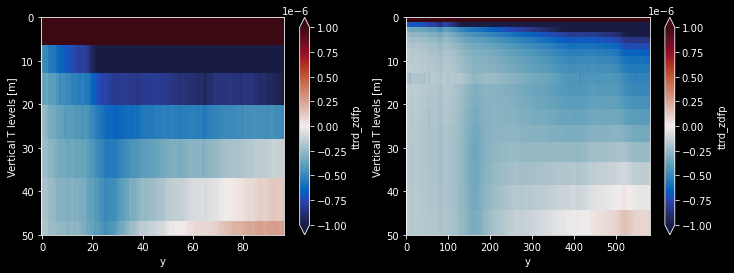

In [85]:
#fig = plt.figure( figsize=(28,4) )
_tend_list = ['zdfp']
nexp = len(_tend_list)
#axgr = AxesGrid(fig, 111, 
#                nrows_ncols=(nexp, 2),
#                axes_pad=0.1,
#                cbar_location='bottom',
#                cbar_mode='single',
#                cbar_pad=0.2,
#                cbar_size='3%',
#                label_mode='')
fig, axs = plt.subplots( nexp, 2, figsize=(12,4) )

vmax = 1e-6
for i in range(0,2):
    for j, t in enumerate(_tend_list):
        tt = 'ttrd_%s' % (t,)
        z = ds_trd_zm[i][tt].mean('year')#.sel(year=1959)
        z.plot(ax=axs[i], vmin=-vmax, vmax=vmax, 
               cmap=cmocean.cm.balance)
        #axs[i].set_title(t)

for ax in axs.flat:
    ax.invert_yaxis()
    ax.set_ylim([50,0])
    


In [56]:
tend_list = ['ad','ldf','zdfp','qsr','qns','npc']

y1, y2 = 1953, 1956

ds_trd = []
for i,t_1m in enumerate(t_1m_all):
    
    if i == 0:
        x1,x2,y1,y2 = xbox1, xbox2, ybox1, ybox2
        _dz = dz_1d_05
    elif i == 1:
        x1,y1 = to_orca12(xbox1, ybox1)
        x2,y2 = to_orca12(xbox2, ybox2) 
        _dz = dz_1d
    
    _res = []
    for t in tend_list:
        
        _trd = (t_1m['ttrd_%s' % (t,)] * _dz).sel(x=slice(x1, x2), y=slice(y1, y2))
        _trdm = _trd.mean(('x','y')).groupby('time.year').mean('time').compute()
        
        _trdm.name = 'ttrd_%s' % (t,)
        _res.append(_trdm.to_dataset())
        
    _ds = xr.merge(_res)
    
    ds_trd.append(_ds)
    

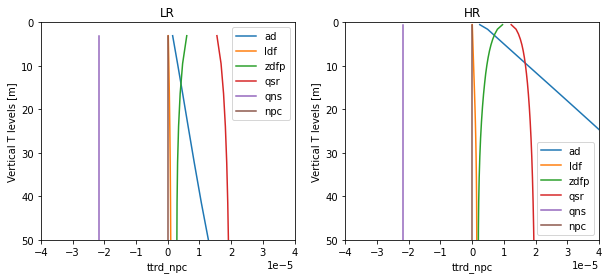

In [68]:
fig1, ax1 = plt.subplots(1,2,figsize=(10,4))

for t in tend_list:
    tt = 'ttrd_%s' % (t,)
    
    for i in range(0,2):
        if i == 0:
            y1, y2 = 1950, 1959
        elif i == 1:
            y1, y2 = 1953, 1958
        
        _z = ds_trd[i][tt].mean('year').cumsum('deptht')
        _z.plot(y='deptht',ax=ax1[i], label=t)

for ax in ax1:
    ax.legend()
    ax.invert_yaxis()
    ax.set_ylim([50,0])

ax1[0].set_xlim([-4e-5,4e-5])
ax1[1].set_xlim([-4e-5,4e-5])
    
ax1[0].set_title('LR')
ax1[1].set_title('HR')

fig1.savefig('figures/SO_sst_bias_tendencies_profiles.pdf',format='pdf')